## Edited-MRS Preprocessing and Data Format

This notebook is a tutorial through the basics of Edited Magnetic Resonance Spectroscopy Preprocessing and the formats of the data to be used in the challenge.

The preprocessing of edited-MRS data consists in the conversion of time-domain free induction decays into a single frequency domain spectrum. This involves the conversion from time domain to frequency domain, the combination of the many transients (i.e. measurements) to improve signal quality and many denoising techniques also to improve the signal quality and remove artifacts. 

The following figure illustrates the basic preprocessing pipeline, though, there are other more complex implementations available in literature.

(Inserto Picture Here)



### Tutorial Summary

In this tutorial, we'll implement a basic edited-MRS Preprocessing pipeline step by step. The code will be broken in the following steps:

1. Examining Input data format
2. Time domain denoising and signal correction
3. Conversion from time-domain to frequency domain
4. Combination of Transients
5. Subtraction of Subspectra
6. Examining Final Result

In [1]:
# Changing path to access scripts
import sys
sys.path.insert(0,"..")


import numpy as np
import matplotlib.pyplot as plt
import h5py
import data_corruption

### 1.Examining Input Data Format

The input data for preprocessing is a Free Induction Decay (FID). It's a complex decaying oscillation in the time domain that must go through a Fourier Transformation in order to generate a spectrum.

The time array for the FID will be called the `t` array, and its format is ( # of scans x # of time points)

The values for the FID at each point will be given by the `fids` array, in the following format: ( # of scans x # of time points x # of subspectra x # of transients ).

In spectroscopy, the absolute value of the x at any point is not of interest, as the shape of spectrum is what matters. Due to this, it's usual to not display the y-axis label or the values when plotting.

--- Checking data dimensions ---
 t array shape: (1, 2048)
 fids array shape: (1, 2048, 2, 160)



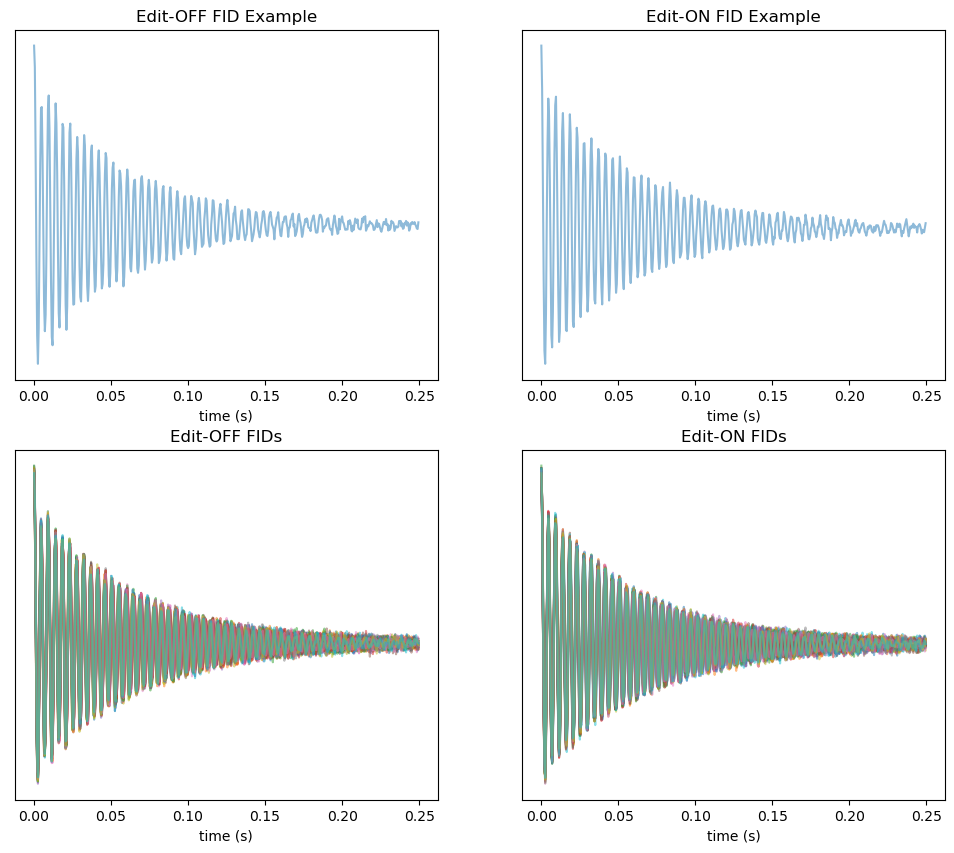

In [2]:
### load sample data and limiting to first scan
with h5py.File("../data/sample_data.h5") as hf:
    gt_fids = hf["ground_truth_fids"][()][:1]
    ppm = hf["ppm"][()][:1]
    t = hf["t"][()][:1]

### adding noise to ground truth so that it's in the same format as an in vivo scan
tm = data_corruption.TransientMaker(gt_fids,t,transients=160)
tm.add_random_amplitude_noise()
tm.add_random_frequency_noise(5,5)
tm.add_random_phase_noise(20,10)
fids = tm.fids

## Checking data format
print("--- Checking data dimensions ---")
print(f" t array shape: {t.shape}")
print(f" fids array shape: {fids.shape}")
print("")

## We'll print a single transient for each subspectra and up to 40 transients of each subspectra, to illustrate the shape of the curve as well as the 
## plurarity of signals
## In all cases, we'll only show the first 500 points to simplify visualization

# transient example to show
transient_number=40

# stop point for plotting time domain
t_stop=500


fig,ax = plt.subplots(2,2,figsize=(12,10))

## plotting example of Fid for each subspectra
## Fid Edit-OFF
ax[0][0].plot(t[0,:t_stop],np.real(fids[0,:t_stop,0,transient_number]),alpha=0.5)
ax[0][0].set_xlabel("time (s)")
ax[0][0].set_title("Edit-OFF FID Example")
ax[0][0].set_yticks([])

## Fid Edit-ON
ax[0][1].plot(t[0,:t_stop],np.real(fids[0,:t_stop,1,transient_number]),alpha=0.5)
ax[0][1].set_xlabel("time (s)")
ax[0][1].set_title("Edit-ON FID Example")
ax[0][1].set_yticks([])


## Ploting a few more examples together
example_count=40
for i in range(0,example_count):
    ax[1][0].plot(t[0,:t_stop],np.real(fids[0,:t_stop,0,i]),alpha=0.5)
    ax[1][1].plot(t[0,:t_stop],np.real(fids[0,:t_stop,1,i]),alpha=0.5)

ax[1][0].set_xlabel("time (s)")
ax[1][0].set_title("Edit-OFF FIDs")
ax[1][0].set_yticks([])
ax[1][1].set_xlabel("time (s)")
ax[1][1].set_title("Edit-ON FIDs")
ax[1][1].set_yticks([])


plt.show()


### 2.Time domain denoising and signal correction

Some denoising and correcting is usually applied at this stage, such as frequency and phase correction and the removal of corrupted transients. The most common frequency and phase correction algorithm is called spectral registration, and it consists in aligning the transients to a refererence through phase and frequency shifts in order to minimize differences.

In this tutorial we'll apply a simple implementation of spectral registration, a frequency and phase correction algorithm.

In [3]:
import spec_reg

fids_corrected = spec_reg.basic_spectral_registration(fids,t)

### 3.Conversion of Time Domain to Frequency Domain

After processing in the time domain it's necessary to shift to the frequency domain. To do so, we perform an inverse fourier transform followed by a frequency shift in the time points dimension. After doing so we'll have the values of the spectral points. In MRS, frequency is usually given in parts per million (ppm). For this challenge, a ppm array will be provided.

We will plot a transient of each subspectra, as well as a collection of transients to exemplify the format of the data. It's possible to see a much larger peak (which goes over the upper limit) at approximately 4.5 ppm. This is the water peak which is an important reference for quantifying the other neurochemicals after preprocessing is complete. The region of interest for quantification is between 5ppm and 0ppm.

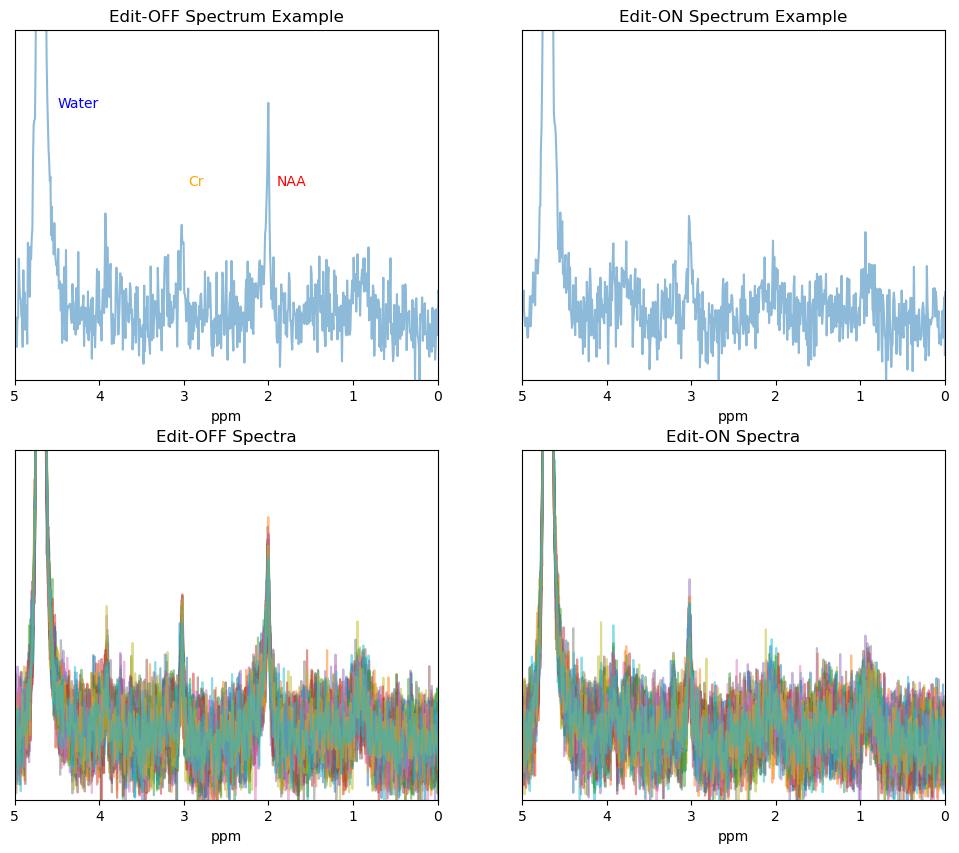

In [4]:
## loading the ppm array
ppm = np.load("data/ppm.npy")

## Converting from time domain to frequency domain
specs = np.fft.fftshift(np.fft.ifft(fids_corrected,axis=1),axes=1)

## Note: A regular fourier transform (fft) could also be used, but then the ppm array would need to be flipped.

## plotting the spectra

# transient example to show
transient_number=40


fig,ax = plt.subplots(2,2,figsize=(12,10))

## plotting example of spectrum for each subspectra
## Subspectra Edit-OFF
ax[0][0].plot(ppm[0,:],np.real(specs[0,:,0,transient_number]),alpha=0.5)
ax[0][0].set_xlabel("ppm")
ax[0][0].set_title("Edit-OFF Spectrum Example")
ax[0][0].set_yticks([])
ax[0][0].set_ylim(-0.5,4)
ax[0][0].set_xlim(0,5)
ax[0][0].text(4.5,3,"Water",color='blue')
ax[0][0].text(2.95,2,"Cr",color='orange')
ax[0][0].text(1.9,2,"NAA",color='red')

## Fid Edit-ON
ax[0][1].plot(ppm[0,:],np.real(specs[0,:,1,transient_number]),alpha=0.5)
ax[0][1].set_xlabel("ppm")
ax[0][1].set_title("Edit-ON Spectrum Example")
ax[0][1].set_yticks([])
ax[0][1].set_ylim(-0.5,4)
ax[0][1].set_xlim(0,5)


## Ploting a few more examples together
example_count=40
for i in range(0,example_count):
    ax[1][0].plot(ppm[0,:],np.real(specs[0,:,0,i]),alpha=0.5)
    ax[1][1].plot(ppm[0,:],np.real(specs[0,:,1,i]),alpha=0.5)

ax[1][0].set_xlabel("ppm")
ax[1][0].set_title("Edit-OFF Spectra")
ax[1][0].set_yticks([])
ax[1][0].set_ylim(-0.5,4)
ax[1][0].set_xlim(0,5)
ax[1][1].set_xlabel("ppm")
ax[1][1].set_title("Edit-ON Spectra")
ax[1][1].set_yticks([])
ax[1][1].set_ylim(-0.5,4)
ax[1][1].set_xlim(0,5)

## reversing x-axis as is usual for spectroscopy
ax[0][0].invert_xaxis()
ax[0][1].invert_xaxis()
ax[1][0].invert_xaxis()
ax[1][1].invert_xaxis()


plt.show()

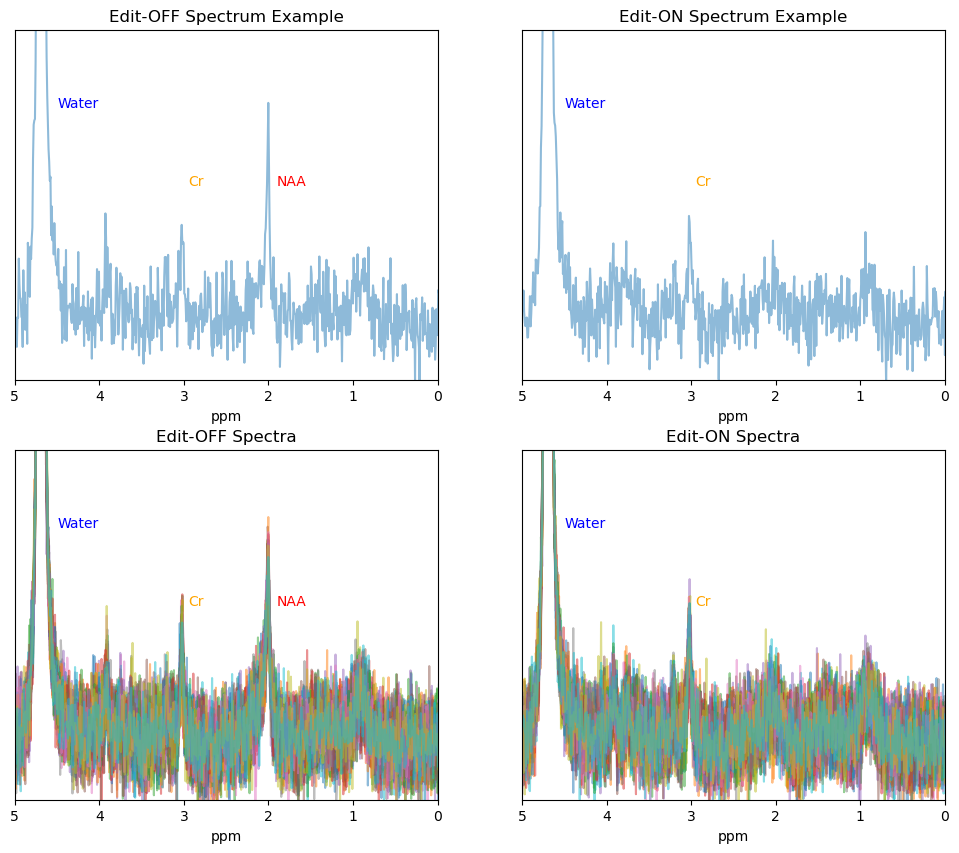

In [5]:
## loading the ppm array
ppm = np.load("data/ppm.npy")

## Converting from time domain to frequency domain
specs = np.fft.fftshift(np.fft.ifft(fids_corrected,axis=1),axes=1)

## Note: A regular fourier transform (fft) could also be used, but then the ppm array would need to be flipped.

## plotting the spectra

# transient example to show
transient_number=40


fig,ax = plt.subplots(2,2,figsize=(12,10))

## plotting example of spectrum for each subspectra
## Subspectra Edit-OFF
ax[0][0].plot(ppm[0,:],np.real(specs[0,:,0,transient_number]),alpha=0.5)
ax[0][0].set_title("Edit-OFF Spectrum Example")

## Fid Edit-ON
ax[0][1].plot(ppm[0,:],np.real(specs[0,:,1,transient_number]),alpha=0.5)
ax[0][1].set_title("Edit-ON Spectrum Example")

## Ploting a few more examples together
example_count=40
for i in range(0,example_count):
    ax[1][0].plot(ppm[0,:],np.real(specs[0,:,0,i]),alpha=0.5)
    ax[1][1].plot(ppm[0,:],np.real(specs[0,:,1,i]),alpha=0.5)

ax[1][0].set_title("Edit-OFF Spectra")
ax[1][1].set_title("Edit-ON Spectra")

# applying formatting for all figures
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel("ppm")
        ax[i][j].set_yticks([])
        ax[i][j].set_ylim(-0.5,4)
        ax[i][j].set_xlim(0,5)
        ax[i][j].invert_xaxis()

        # text notations
        ax[i][j].text(4.5,3,"Water",color='blue')
        ax[i][j].text(2.95,2,"Cr",color='orange')
    ax[i][0].text(1.9,2,"NAA",color='red')



plt.show()

### 4 Combination of Transients

The combination of the transients is done to improve signal quality, to cancel noise while maintaining the signal. There are several algorithms for the combination of the transients, but the simplest one is to average the transients. This is done for both the edit-ON and edit-OFF subspectra.

In [6]:
# averaging over transient dimension
combined_specs = specs.mean(axis=3)

print(f"new dimension: {combined_specs.shape}")

new dimension: (1, 2048, 2)


### 5 Subtraction of subspectra

In order to obtain the GABA-edited Spectrum, we need to subtract the edit-OFF subspectra from the edit-ON subspectra. This cancels most of the signal at 3ppm and reveals the GABA peak, which we wish to analyze.

We'll calculate the difference spectrum and plot the spectra of this operation.

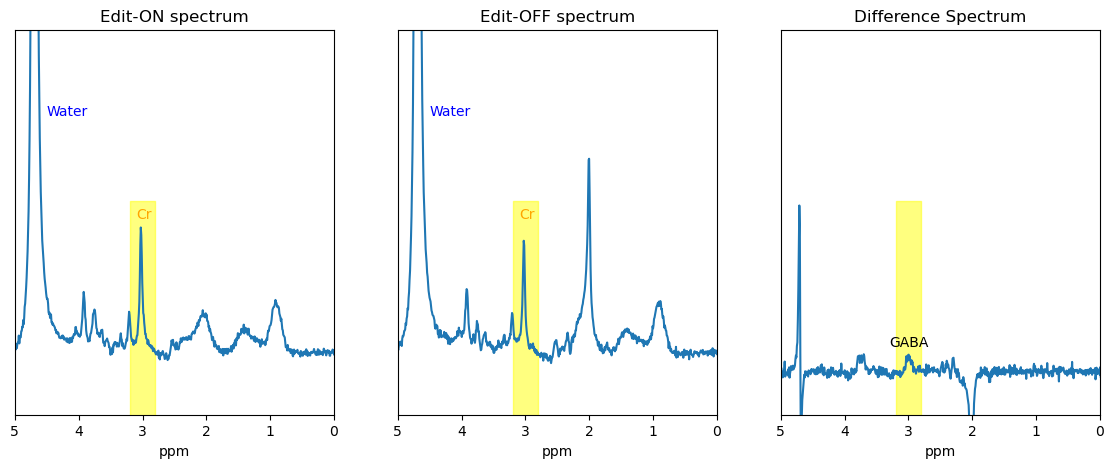

In [7]:
## subtracting subspectra
diff_spec = combined_specs[:,:,1]-combined_specs[:,:,0]


## plotting steps side by side
fig,ax = plt.subplots(1,3,figsize=(14,5))

## plotting parts
ax[0].plot(ppm[0,:],np.real(combined_specs[0,:,1]))
ax[1].plot(ppm[0,:],np.real(combined_specs[0,:,0]))
ax[2].plot(ppm[0,:],np.real(diff_spec[0,:])
)
# selecting ymin and ymax so plots are comparable
ymin = min(np.real(combined_specs).min(),np.real(diff_spec).min())
ymax = max(np.real(combined_specs).max(),np.real(diff_spec).max())

for i in range(3):
    ax[i].set_yticks([])
    ax[i].set_xlabel("ppm")
    ax[i].set_xlim(0,5)
    ax[i].set_ylim(-0.5,4)
    ax[i].invert_xaxis()
    ax[i].fill_between([2.8,3.2],-2,2,color="yellow",alpha=0.5)

    if i<2:
        ax[i].text(4.5,3,"Water",color='blue')
        ax[i].text(3.1,1.8,"Cr",color='orange')
    else:
        ax[i].text(3.3,0.3,"GABA",color='black')

ax[0].set_title("Edit-ON spectrum")
ax[1].set_title("Edit-OFF spectrum")
ax[2].set_title("Difference Spectrum")

plt.show()

### 6 Examining Final Result

The difference spectrum is the final result of the MRS preprocessing and it will be the spectrum analyzed for quantifying the neurochemicals of interest. For the GABA-edited MRS, we have that the peak of interest is the one at 3ppm, highlighted in the following plot.

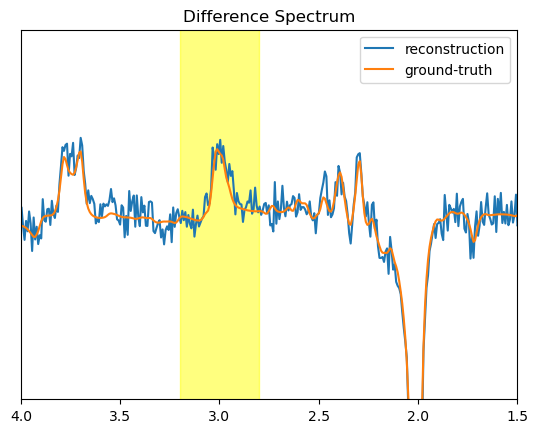

In [8]:
## plotting diff result and region of interest as well as comparison with ground-truth

## getting ground-truth and converting to spectrum
y = np.load("data/y.npy")
y_diff = y[0,:,1] - y[0,:,0]

fig,ax = plt.subplots(1)

ax.plot(ppm[0,:],np.real(diff_spec[0,:]),label="reconstruction")
ax.plot(ppm[0,:],np.real(y_diff[:]),label="ground-truth")

ax.fill_between([2.8,3.2],-2,2,color="yellow",alpha=0.5)
ax.set_yticks([])
ax.set_xlim(1.5,4)
ax.set_ylim(-0.5,0.5)

ax.set_title("Difference Spectrum")
ax.invert_xaxis()

plt.legend()
plt.show()

### Extra - Effect of number of transients

we'll now see the effect of the number of transients in the quality of the reconstruction in a visual manner, by plotting the resulting reconstruction when using 80, 160, 240 and 320 transients.

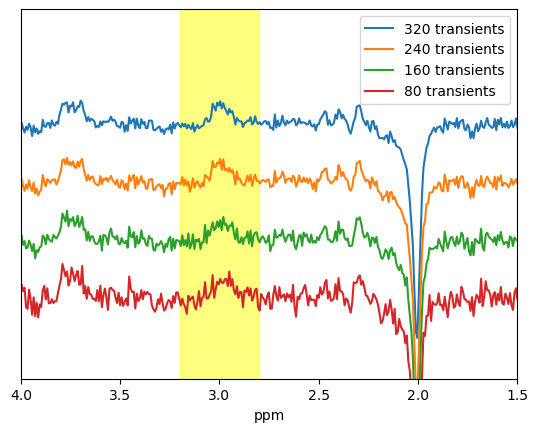

In [9]:


fig,ax = plt.subplots()

diff_specs = specs[0,:,1,:]-specs[0,:,0,:]

y_offset=0.5
transient_counts = [320,240,160,80]
# taking advantage of the specs variable previously used:
for i in range(len(transient_counts)):
    ax.plot(ppm[0,:],np.real(diff_specs[:,:transient_counts[i]//2].mean(axis=1))+(len(transient_counts)-i)*y_offset,label=f"{transient_counts[i]} transients")

ax.set_yticks([])
ax.set_xlabel("ppm")
ax.set_xlim(1.5,4)
ax.set_ylim(-0.2,1 + y_offset*len(transient_counts))
ax.invert_xaxis()
ax.fill_between([2.8,3.2],-2,5,color="yellow",alpha=0.5)

plt.legend()
plt.show()
